In [3]:
import requests as rq
import os
from dotenv import load_dotenv
load_dotenv()

True

In [12]:
URL = os.getenv("URL")

params= {
    'start_date': '2024-03-15',
    'end_date' : '2024-04-14'
}

try:
    response = rq.get(URL, params=params)
    data = response.json()
   
except rq.exceptions.HTTPError as err:
    raise SystemExit(err)

### ¿Cuántos días se obtienen de datos?

In [51]:
print(data["total_days"])

30


## Limpieza de datos

En la petición se obtuvieron el total de 30 dias

In [13]:
import pandas as pd

In [84]:
clean_data = data['data']
df = pd.DataFrame(clean_data)
df = df.reset_index()
df = df.rename(columns={'index': 'hora'})
df_long = pd.melt(df, id_vars=['hora'], var_name='fecha', value_name='precio')
df_temp = df_long["hora"].str.replace("24:00","00:00", regex=True)
df_long["hora"] = df_temp
df_long["fecha"] = pd.to_datetime(df_long["fecha"])
df_long

,hora,fecha,precio
0,01:00,2024-03-15,551.70
1,02:00,2024-03-15,551.70
2,03:00,2024-03-15,551.70
3,04:00,2024-03-15,497.36
4,05:00,2024-03-15,551.70
...,...,...,...
715,20:00,2024-04-14,1056.17
716,21:00,2024-04-14,1056.17
717,22:00,2024-04-14,1056.17
718,23:00,2024-04-14,1056.17


In [47]:
print(df_long.isnull().sum())

hora      0
fecha     0
precio    4
dtype: int64


In [70]:
df_long[df_long["precio"].isnull()]

,hora,fecha,precio
566,15:00,2024-04-08,NaN
590,15:00,2024-04-09,NaN
591,16:00,2024-04-09,NaN
592,17:00,2024-04-09,NaN


### ¿Cuáles son las horas donde hacen falta valores?
15:00	2024-04-08	NaN	15:00	2024-04-09	NaN1	16:00	2024-04-09	Na92	17:9
Estas son loas horas faltantes

Remplazar datos nulos

In [78]:
precio_nan = df_long[df_long["precio"].isnull()].index
for x in precio_nan:
    if x > 0:
        df_long.loc[x, "precio"] = df_long.loc[x - 1, "precio"]

In [82]:
print(df_long.isnull().sum())


hora      0
fecha     0
precio    0
dtype: int64


## Cálculos de Promedios

In [157]:
promedio_df = df_long.groupby('fecha')['precio'].mean().reset_index()
promedio_df = promedio_df.rename(columns={'precio': 'precio_promedio'})
promedio_df['precio_7d'] = promedio_df['precio_promedio'].rolling(window=7).mean()
promedio_df

,fecha,precio_promedio,precio_7d
0,2024-03-15,557.669167,NaN
1,2024-03-16,574.449167,NaN
2,2024-03-17,581.365000,NaN
3,2024-03-19,617.401667,NaN
4,2024-03-20,625.661667,NaN
5,2024-03-21,654.168333,NaN
6,2024-03-22,707.120417,616.833631
7,2024-03-23,715.151250,639.331071
8,2024-03-24,651.767500,650.376548
9,2024-03-25,735.623333,672.413452


## Visualización

In [158]:
import matplotlib.pyplot as plt

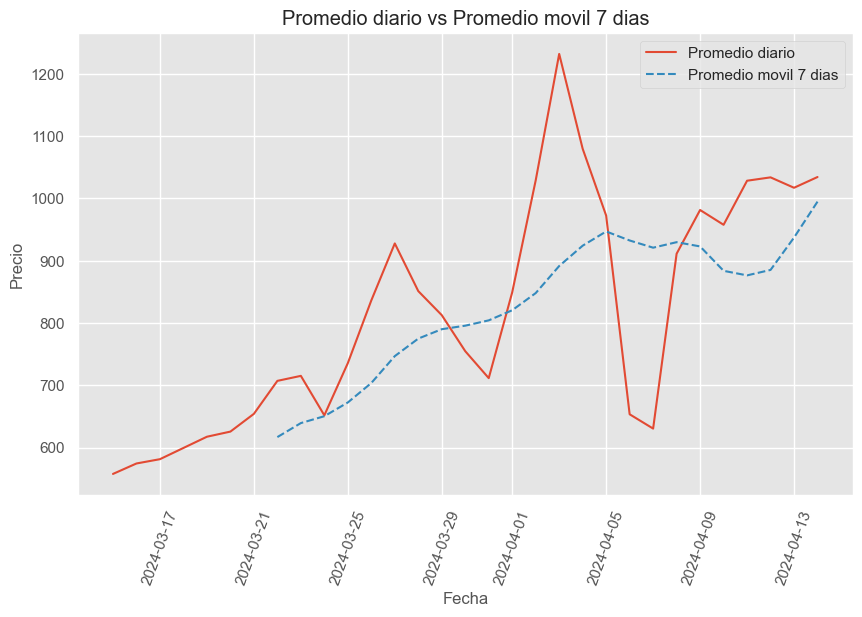

In [159]:
plt.style.use('ggplot')
plt.plot(promedio_df["fecha"], promedio_df["precio_promedio"], label="Promedio diario")
plt.plot(promedio_df["fecha"], promedio_df["precio_7d"],linestyle='dashed', label="Promedio movil 7 dias")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.title("Promedio diario vs Promedio movil 7 dias")
plt.xticks(rotation=70)
plt.legend()
plt.savefig('image.png')
plt.show()

## ¿Cuál es el comportamiento del precio para el periodo?

El comportamiento del precio es variante. Se observa tanto por el promedio diario como el movil de 7 dias que seguira subiendo el precio.

## Almacenamiento de Resultados

In [162]:
import sqlite3

conn = sqlite3.connect('precios.db')
try:
    conn.execute("""CREATE TABLE Precio (
                              fecha DATATIME,
                              precio_promedio FLOAT,
                              precio_7d FLOAT
                        )""")
    print("se creo la tabla Precio")                        
except sqlite3.OperationalError:
    print("La tabla Precio ya existe")   

se creo la tabla Precio


In [163]:
promedio_df.to_sql("Precio", conn, if_exists='append', index=False)

30

In [164]:
conn.close()